# W207 Final Project: Pulmonary Nodule Segmentation

By: Jun Cao, Leyla Greengard, and Susmita Padala

Report Completed: 4/12/2021

## Introduction

Our goal is, given the CT scans of a lung, we segment the image to identify nodules in the lung. Today, identification and classification of lung nodules are done by experienced annotators. We aim to build a model that can segment a lung CT scan and predict the existence of a nodule.

The dataset we are using is from a public dataset called Lung Nodule Analaysis 2016 (LUNA-16). It has a total of 888 CT scans. There are a total of 1186 nodules for 601 of those CT scans. The annotations file contatins the x,y,z coordinates of each nodule with a size >= 3mm and its corresponding CT scan. The data files take up approximately 115 GB of data.

In [1]:
#
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
#
import SimpleITK as sitk
#
import glob
import os
import json
#
from skimage import morphology, measure, exposure, img_as_float, exposure
#
from sklearn.cluster import KMeans
from skimage.transform import resize
import tensorflow as tf

#
from tqdm import tqdm


## Data

### EDA

Raw data is stored in `.mhd` and `.raw` file format. `.mhd` file has all the metadata of the image and `.raw` is the image itself. File is named by `seriesuid`, which is consistant with `annotation.csv` file.

We use `simpleITK` package to load images. Images have several useful metadata, such origin and spacing, which will be used later for data preparation. Below is an example of image metadata. 

In [2]:
# data path
data_path = '/Users/jun/luna_data/'
files = glob.glob(data_path + '**/*.mhd', recursive=True)

In [3]:
# load image
itk_img = sitk.ReadImage(files[0])
# meta data
origin = np.array(itk_img.GetOrigin())
spacing = np.array(itk_img.GetSpacing())
print("For CT image {0}, \nthe origin is {1}mm, {2}mm, {3}mm, \nand spacing \
of voxels are {4}mm, {5}mm, {6}mm with x, y, z respectively in world coordinates."\
      .format(files[0], origin[0], origin[1], origin[2], spacing[0], spacing[1], spacing[2]))

For CT image /Users/jun/luna_data/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.103115201714075993579787468219.mhd, 
the origin is -228.800003mm, -220.0mm, -286.5mm, 
and spacing of voxels are 0.859375mm, 0.859375mm, 1.25mm with x, y, z respectively in world coordinates.


There are 888 CT scans in total. The CT scan is a set of axial slices of the lung. Each CT scan has different number of slices, ranging from 200 to 600. We can transform the image into a numpy array. As the example below, the array has shape (219, 512, 512), which means there are 219 slice images and each image is 512x512.

In [4]:
print("There are total of {0} CT scans.".format(len(files)))
img_array = sitk.GetArrayFromImage(itk_img)
print(img_array.shape)

There are total of 888 CT scans.
(219, 512, 512)


The table below, has the annotated nodule locations and diameter for each CT scan.

In [5]:
df_node = pd.read_csv(data_path+"annotations.csv")
df_node.head()

,seriesuid,coordX,coordY,coordZ,diameter_mm
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-128.699421,-175.319272,-298.387506,5.651471
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,103.783651,-211.925149,-227.121250,4.224708
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...,69.639017,-140.944586,876.374496,5.786348
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,-24.013824,192.102405,-391.081276,8.143262
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,2.441547,172.464881,-405.493732,18.545150


Here we look at the aggregate distribution of nodules within the lungs. The (x,y) plane is the plane of the CT scans, or a horizontal cross section for a person who is standing up. The z direction is the vertical direction for a person who is standing up.

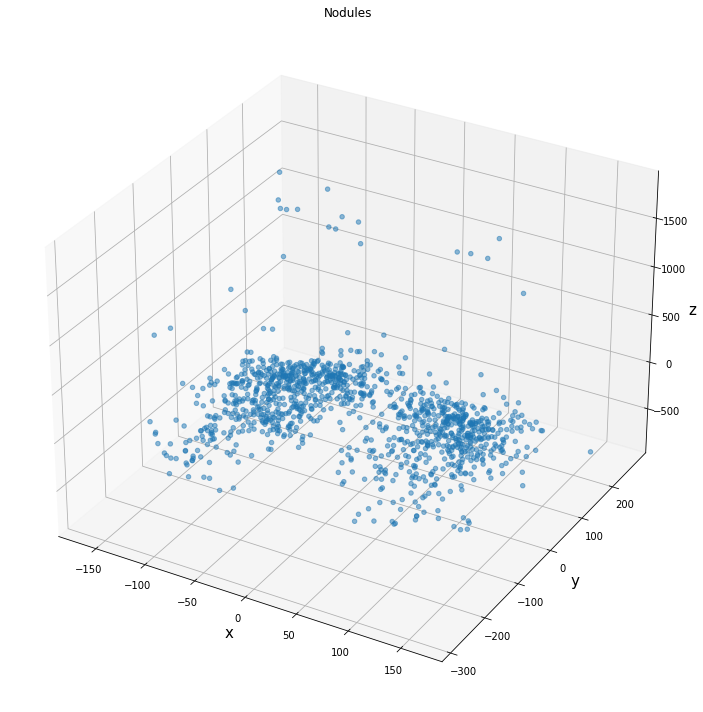

In [7]:
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams["figure.figsize"]=10,10
#plt.rcParams["figure.dpi"]=50

fig = plt.figure() 
# 3-D projection 
ax = plt.axes(projection ='3d') 
ax.scatter(df_node.coordX,df_node.coordY, df_node.coordZ,alpha = 0.5, s=20, depthshade=True)   
ax.set_title('Nodules') 
ax.set_xlabel('x',fontsize = 15)
ax.set_ylabel('y',fontsize = 15)
ax.set_zlabel('z',fontsize = 15)
fig.tight_layout()
plt.show() 

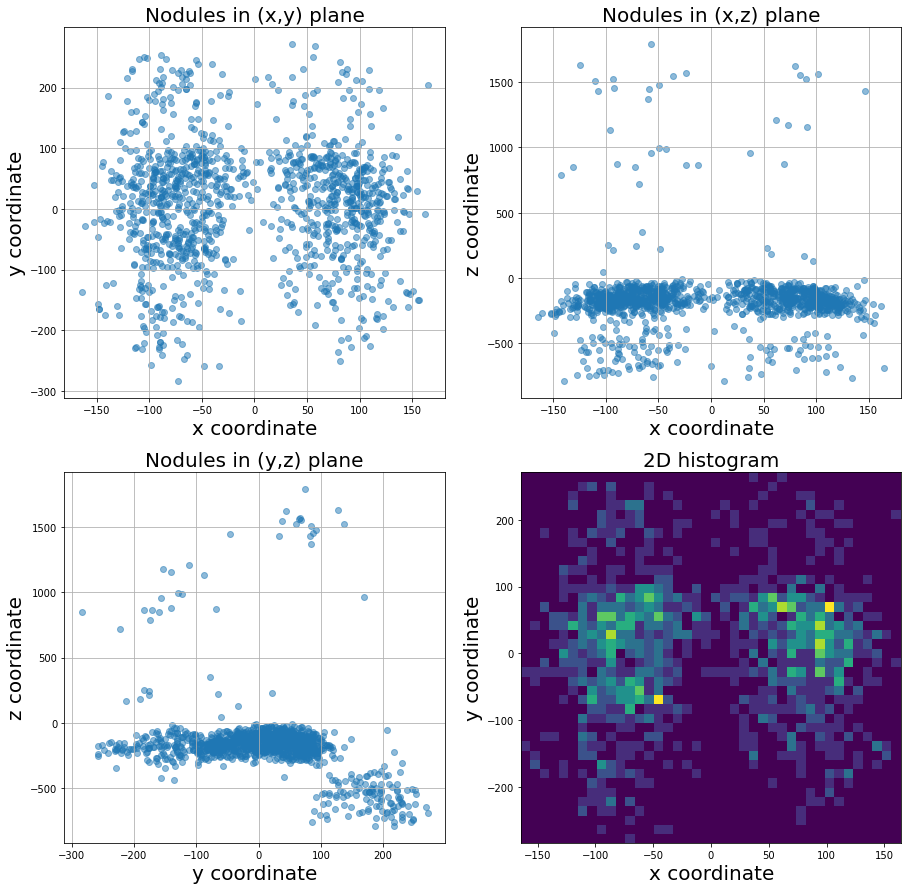

In [8]:
plt.rcParams["figure.figsize"]=15,15
#plt.rcParams["figure.dpi"]=90
fig, ax = plt.subplots(2,2)
ax[0,0].scatter(df_node.coordX,df_node.coordY,alpha=0.5)

ax[0,0].set_xlabel("x coordinate", fontsize=20)
ax[0,0].set_ylabel("y coordinate", fontsize=20)
ax[0,0].set_title('Nodules in (x,y) plane',fontsize=20)
ax[0,0].grid(True)

ax[0,1].scatter(df_node.coordX,df_node.coordZ,alpha=0.5)
ax[0,1].set_xlabel("x coordinate", fontsize=20)
ax[0,1].set_ylabel("z coordinate", fontsize=20)
ax[0,1].set_title('Nodules in (x,z) plane',fontsize=20)
ax[0,1].grid(True)

ax[1,0].scatter(df_node.coordY,df_node.coordZ,alpha=0.5)
ax[1,0].set_xlabel("y coordinate", fontsize=20)
ax[1,0].set_ylabel("z coordinate", fontsize=20)
ax[1,0].set_title('Nodules in (y,z) plane',fontsize=20)
ax[1,0].grid(True)

ax[1,1].hist2d(df_node.coordX, df_node.coordY, bins=40)
ax[1,1].set_xlabel("x coordinate", fontsize=20)
ax[1,1].set_ylabel("y coordinate", fontsize=20)
ax[1,1].set_title('2D histogram',fontsize=20)

plt.show()

In the diagram above, nodules are concentrated toward the middle of the lungs. There is a large concentration of nodules in a small area of the vertical axis.
The bottom right graph is a histogram of the number of nodules at each point of the (x,y) plane. The lighter colors represent a higher number of nodules.

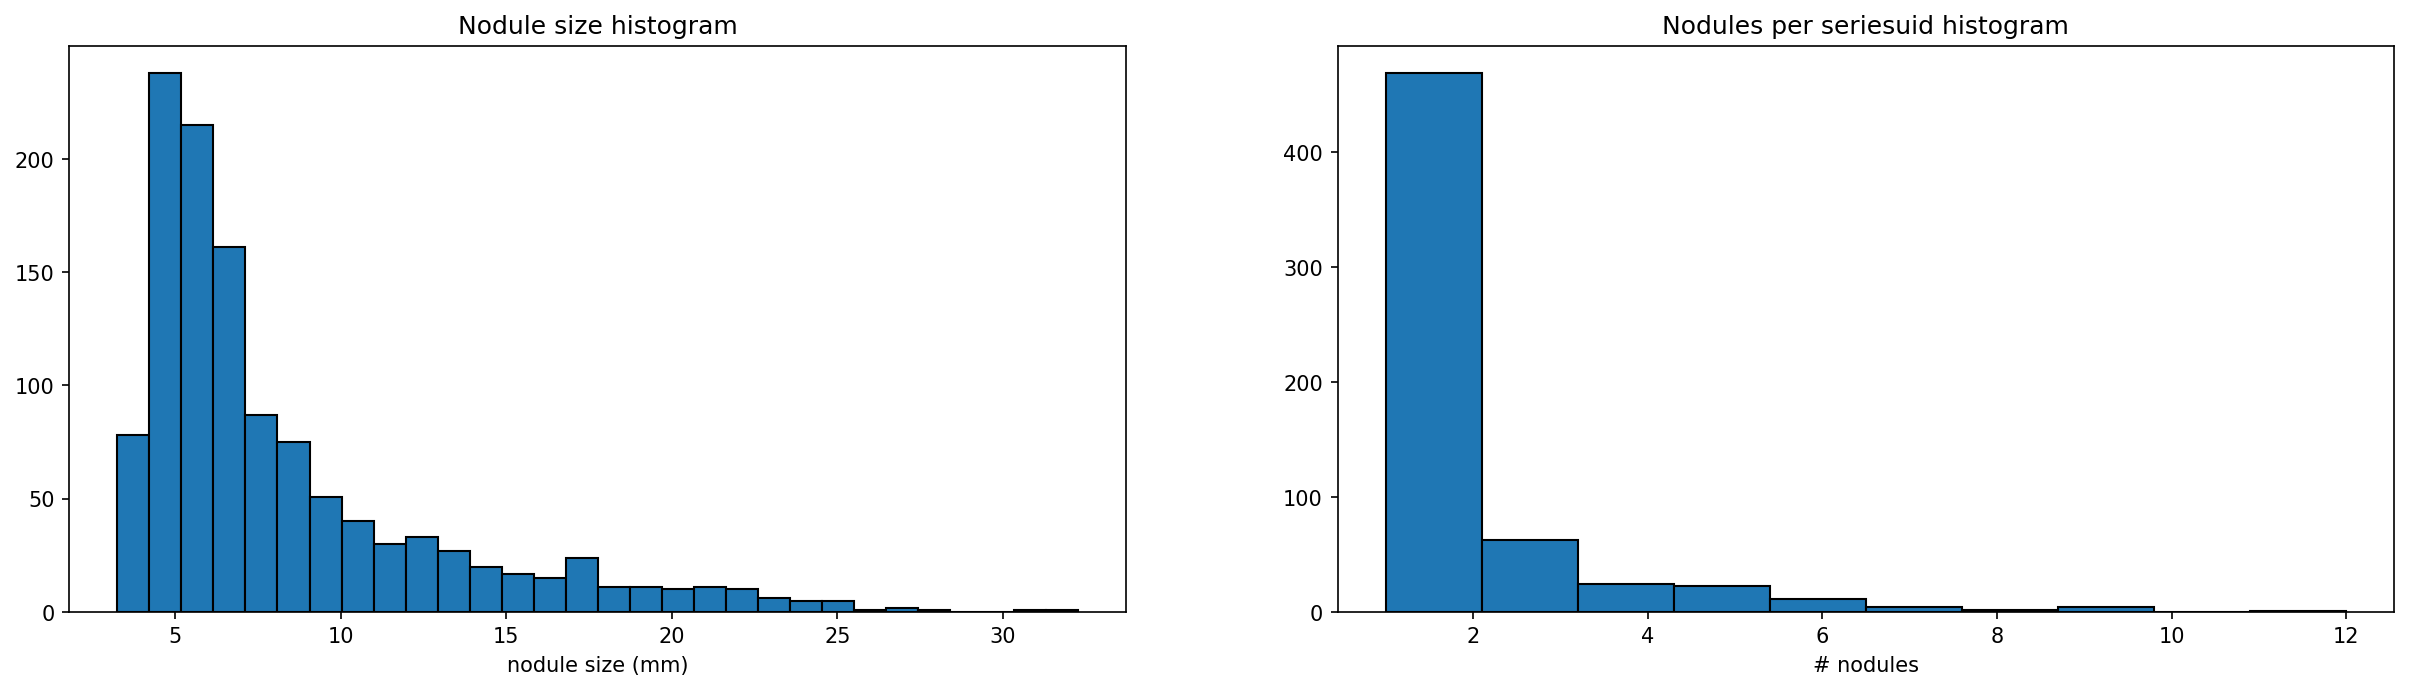

Nodules per seriesuid:


count    601.000000
mean       1.973378
std        1.483000
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max       12.000000
Name: seriesuid, dtype: float64

In [9]:
## Number of nodules per seriesuid and sizes of nodules
#Number of unique seriesuid's
n = len(pd.unique(df_node['seriesuid']))
#total number of seriesuid's
n = len((df_node['seriesuid']))
num_nodules=df_node["seriesuid"].value_counts()

plt.rcParams["figure.figsize"]=20,5
plt.rcParams["figure.dpi"]=150
fig, ax = plt.subplots(1,2)
ax[0].hist(df_node.diameter_mm,edgecolor="black",bins=30)
ax[0].set_xlabel("nodule size (mm)")
ax[0].set_title('Nodule size histogram')
ax[1].hist(num_nodules,edgecolor="black")
ax[1].set_xlabel("# nodules")
ax[1].set_title('Nodules per seriesuid histogram')
plt.show()
#ax.grid(True)
#fig.tight_layout()

print("Nodules per seriesuid:")
num_nodules.describe()

Most scans have one nodule. <br>
The majority of nodules are 4 to 6 mm wide in diameter. 

### Data Preparation


We want to create a dataset for training. We need images with nodule to be training data, and create nodule mask to be training label. 

We use `annotation.csv` file to access nodule information. The `seriessuid` column is the id of CT image, we will use this information to create a new column to specify the corresponding image file. 

The goal of data preparation is to have a set of images as input data and a set of corresponding nodule masks as output labels. We first select images that have nodules listed in the `annotation.csv` file, and then generate nodule mask based on nodule information.

Before we go farther into details, it is worth to spend some time to understand coordination system in CT scan. 

There are two types of coordinate. One is called world coordinate. This coordinate is defined by CT scanner. The other one is called voxel coordinate, which directly relates to the image numpy array shape. Below is an illustration of the relationship between world coordinate and voxel coordinate.

![coordinate](imgs/coordinate.svg)

Below is the function to transform world coodinate to voxel coordinate.

In [6]:
def world_to_voxel(world_coord, origin, spacing):
    """
    transform world_coord to voxel_coord by meta information contained in itk_image
    """
    world_coord = world_coord.astype("float64")
    voxel_coord = np.rint((world_coord - origin) / spacing)
    voxel_coord = voxel_coord.astype('int32')
    return voxel_coord

We use `anotation.csv` to access nodule information. We first add a column `file_name` to associate each nodule with its corresponding CT scan. 

In [7]:
def add_file_column(df_node, file_list):
    
    def get_filename(file_list, seriesuid):
        for file_name in file_list:
            if seriesuid in file_name:
                return file_name

    df_node["file_name"] = df_node["seriesuid"].map(lambda seriesuid: get_filename(file_list, seriesuid))

add_file_column(df_node, files)
df_node.head()

,seriesuid,coordX,coordY,coordZ,diameter_mm,file_name
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-128.699421,-175.319272,-298.387506,5.651471,/Users/jun/luna_data/subset8/1.3.6.1.4.1.14519...
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,103.783651,-211.925149,-227.121250,4.224708,/Users/jun/luna_data/subset8/1.3.6.1.4.1.14519...
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...,69.639017,-140.944586,876.374496,5.786348,/Users/jun/luna_data/subset5/1.3.6.1.4.1.14519...
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,-24.013824,192.102405,-391.081276,8.143262,/Users/jun/luna_data/subset2/1.3.6.1.4.1.14519...
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,2.441547,172.464881,-405.493732,18.545150,/Users/jun/luna_data/subset2/1.3.6.1.4.1.14519...


`coordX`, `coordY` and `coordZ` in this data frame are coordination in world coordinate. 
`coordZ` relates to number of slices in CT scan. We can use this information to know which image slice the nodule locate. 

We create a helper function `get_img_info` to extract useful information from the dataframe, such as image numpy array, nodule center location, diameter, voxel origin and spacing. 

In [8]:
def get_img_info(node_info):
    # helper function to extract useful information from the nodule data frame.
    node_center = node_info["coordX": "coordZ"].to_numpy() # nodule center location in world coordinate space
    file = node_info["file_name"]    
    # read CT image from .mhd file
    itk_image = sitk.ReadImage(file)
    # images array is a three dimensional numpy array
    # it is in voxel space but with (z, y, x) order
    images_array = sitk.GetArrayFromImage(itk_image) 
    origin = np.array(itk_image.GetOrigin()) # get orgin in world coordinate space
    spacing = np.array(itk_image.GetSpacing()) # get spacing (mm) between pixels in world coordinate space
    diam = node_info["diameter_mm"]
    return images_array, node_center, diam, origin, spacing

Testing `get_img_info` function.

In [9]:
# testing get_img_info
i_ex = 800
node_ex = df_node.iloc[i_ex]
images_array, node_center, diam, origin, spacing = get_img_info(node_ex)
print("images_array: {}, \n node_center: {}, \n diameter: {}, \n origin: {}, \n spacing: {}".format(pd.Series(images_array[0].flatten()).describe(), node_center, diam, origin, spacing))

images_array: count    262144.000000
mean       -770.214371
std        1217.931492
min       -3024.000000
25%        -992.000000
50%         -95.000000
75%          30.000000
max        1487.000000
dtype: float64, 
 node_center: [92.75491946 28.68047227 -68.42174667], 
 diameter: 14.01055468, 
 origin: [-161.199997 -176.199997 -284.76001 ], 
 spacing: [0.66406202 0.66406202 1.25      ]


We transform `coordZ` into voxel coordinate, which indicates the slice to select. We also select two additional images, which sit above and below to make dataset size bigger. The `generate_images_array` is designed to do this job. The return of this function is a numpy array of shape `(3, 512, 512)`. 

In [10]:
def generate_images_array(images_array, node_center, origin, spacing):
    """
    given nodule and image information, return image numpy array of corresponding images
    """
    # node center location in voxel space
    node_center_voxel_coord = world_to_voxel(node_center, origin, spacing)
    # ith image where nodule locate
    i = node_center_voxel_coord[2]
    # also keep the images above and below to increase data size
    # use clip to prevent out of bound
    max_z = images_array.shape[0] - 1
    v_zrange = np.array([i-1, i, i+1]).clip(0, max_z)
    images_with_node = images_array[v_zrange]
    return images_with_node

The `generate_node_mask` function is to draw the nodule mask from given nodule information. The idea is to first create a 512x512 zero array. Then define the boundary of nodule using nodule center and nodule diameter, and then fill in 1 inside the boundary if the distance between the pixel and nodule center is less than diameter.

In [11]:
def generate_node_mask(node_center, diam, origin, spacing):
    """
    draw nodule mask
    """
    width = 512
    height = 512
    
    masks = np.zeros([3, height, width]) # create a 0's array matchs the shape of x-ray image

    # transform to voxel space from world coordinates
    v_center = world_to_voxel(node_center, origin, spacing)
    v_diam = int(diam / spacing[0] + 5) # add 5 pixels to make the mask bigger
    
    # Defining the voxel range in which the nodule falls
    v_xmin = np.max([0, int(v_center[0] - v_diam) - 5])
    v_xmax = np.min([width - 1, int(v_center[0] + v_diam) + 5])
    
    v_ymin = np.max([0, int(v_center[1] - v_diam) - 5]) 
    v_ymax = np.min([height - 1, int(v_center[1] + v_diam) + 5])

    v_xrange = range(v_xmin, v_xmax + 1)
    v_yrange = range(v_ymin, v_ymax + 1)
    
    max_z = images_array.shape[0] - 1
    i = v_center[2]
    v_zrange = np.array([i-1, i, i+1]).clip(0, max_z)
    
    # Fill in 1 within sphere around nodule
    # Spacing might be different across x and y axis
    # Therefore it is better to mesure in world coordinate
    i = 0
    for v_z in v_zrange:
        w_z = spacing[2] * v_z + origin[2]
        
        for v_x in v_xrange:
            w_x = spacing[0] * v_x + origin[0]
            
            for v_y in v_yrange:          
                w_y = spacing[1] * v_y + origin[1]

                if np.linalg.norm(node_center - np.array([w_x, w_y, w_z])) <= diam:
                    masks[i, int((w_y-origin[1])/spacing[1]), int((w_x-origin[0])/spacing[0])] = 1.0
                    
        i += 1
                    
    return masks  

Now we have functions to select images and generate nodule masks. We then combined those functions into a single function for simplicity. 

In [12]:
def generate_imgs_masks(node_info):
    """
    combines functions defined above into a single function
    given a dataframe row
    return corresponding images and nodule masks
    """
    images_array, node_center, diam, origin, spacing = get_img_info(node_info)
    imgs = generate_images_array(images_array, node_center, origin, spacing)
    masks = generate_node_mask(node_center, diam, origin, spacing)
    return imgs, masks

Testing `generate_imgs_masks`. It returns 2 numpy arrays, one for CT images and one for masks. Each array consists of 3 images.

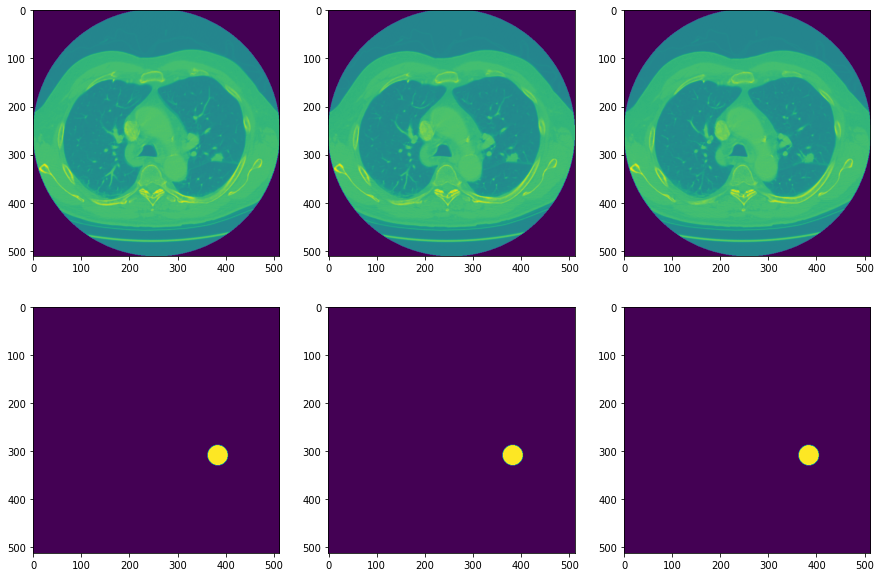

In [13]:
# testing
imgs, masks = generate_imgs_masks(node_ex)
fig, axs = plt.subplots(2, 3, figsize=[15, 10])
for i in range(3):
    axs[0, i].imshow(imgs[i])
    axs[1, i].imshow(masks[i])

Then apply this function to all nodules listed in `annotations.csv` files and then save the outputs as `.npy` files.

In [14]:
def create_data(data_path, testing=False):
    # Select images and generate masks for every nodule in `annotation.csv`.
    if testing:
        # test on 1 subset of data
        file_list = glob.glob(data_path + 'subset0/*.mhd')
        output_path = data_path + "test_output/"
    else:
        file_list = glob.glob(data_path + '**/*.mhd', recursive=True)
        output_path = data_path + "output/"
        
    df_node = pd.read_csv(data_path+"annotations.csv")
    add_file_column(df_node, file_list)
    
    for i in tqdm(df_node.index):
        node_info = df_node.loc[i]
        if node_info["file_name"] in file_list:
            imgs, masks = generate_imgs_masks(df_node.loc[i])
            np.save(os.path.join(output_path, "images_{:04d}.npy".format(i)), imgs)
            np.save(os.path.join(output_path,"node_masks_{:04d}.npy".format(i)), masks)
    print("Data generation completed!")

In [471]:
# generate images and node masks
create_data(data_path)

100%|██████████| 1186/1186 [03:21<00:00,  5.90it/s]

Data generation completed!


### Image Preprocessing

Now we have all data ready for machine learning. But this dataset has a lot of room for improvement. 

For the purpose of this project, the region of interest (ROI) is the lung. The CT image has a lot of noise and only about half of the image size representing lung. It has a big portion that falls outside of CT scanner. It also shows other tissues, such as bones and muscles. If the image only has the region of interest, it would be much more effecient to train the machine learning model. 

To achieve this, we are going to create a lung mask, which only has the lung region, and then apply this lung mask to crop the CT image. We then resize the image to make the ROI bigger.

Creating lung mask is essentially seperating radiopaque tissue and radio transparent tissue. Radiopaque tissue is darker than radio transparent tissue. We use k-means to seperate these two groups, and then take the average of centroids to be the threadshold. 

In [15]:
# make lung mask

def standardize_img(img):
    mean = np.mean(img)
    std = np.std(img)
    img = img - mean
    img = img / std
    # Find the average pixel value near the lungs
    # to renormalize washed out images
    middle = img[100:400,100:400] 
    mean = np.mean(middle)  
    max = np.max(img)
    min = np.min(img)
    # moving the underflow and overflow on the pixel spectrum
    img[img==max]=mean
    img[img==min]=mean
    return img

def thresholding(img, classes=2):
    img = standardize_img(img)
 
    # Using Kmeans to separate radiopaque tissue
    # and radio transparent tissue
    # Doing this only on the center of the image to avoid 
    # the non-tissue parts of the image as much as possible

    middle = img[100:400,100:400] 
    model = KMeans(n_clusters=2).fit(np.reshape(middle,[np.prod(middle.shape),1]))
    centers = sorted(model.cluster_centers_.flatten())
    threshold = np.mean(centers)
    thresh_img = np.where(img<threshold, 1.0, 0.0)
    return thresh_img

(-0.5, 511.5, 511.5, -0.5)

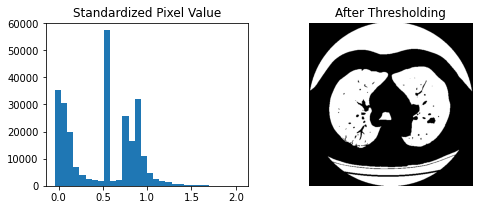

In [16]:
# testing thresholding
img_file = os.path.join(data_path, 'output/images_{:04d}.npy'.format(i_ex))
img = np.load(img_file)[0]
img_stand = standardize_img(img)
img_thred = thresholding(img)

fig, axs = plt.subplots(1, 2, figsize=[8, 3])

axs[0].hist(img_stand.flatten(), bins=30)
axs[0].set_title('Standardized Pixel Value')

axs[1].imshow(img_thred, cmap='gray')
axs[1].set_title('After Thresholding')
axs[1].axis('off')

The histogram confirms the two groups assumption. The pixel value around 0.6 is the background value. 

We then apply morphological opening by erosion with a 4x4 structuring element and then dilation with a 10 x 10 structuring element. The purpose of morphological opening is to remove small pixels inside lung region.

In [17]:
def opening(img, ero_struc=np.ones((4, 4)), dil_struc=np.ones((10, 10))):
    img_erosion = morphology.erosion(img, ero_struc)
    img_dilation = morphology.dilation(img_erosion, dil_struc)
    return img_dilation

(-0.5, 511.5, 511.5, -0.5)

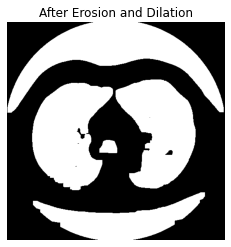

In [18]:
img_open = opening(img_thred, np.ones((4, 4)), np.ones((10, 10)))
fig, ax = plt.subplots(1, 1, figsize=[4, 4])
ax.imshow(img_open, cmap='gray')
ax.set_title('After Erosion and Dilation')
ax.axis('off')

The last step is to region properties to keep the lung region and set everything else to 0.

In [19]:
def make_lung_mask(proc_img):
    labels = measure.label(proc_img)
    label_vals = np.unique(labels)
    regions = measure.regionprops(labels)
    good_labels = []
    for prop in regions:
        B = prop.bbox
        if B[2]-B[0]<475 and B[3]-B[1]<475 and B[0]>40 and B[2]<472:
            good_labels.append(prop.label)
    mask = np.ndarray([512,512],dtype=np.int8)
    mask[:] = 0

    #  After just the lungs are left, we do another large dilation
    #  in order to fill in and out the lung mask 
    for N in good_labels:
        mask = mask + np.where(labels==N,1,0)
    mask = morphology.dilation(mask,np.ones([10,10]))
    return mask

(-0.5, 511.5, 511.5, -0.5)

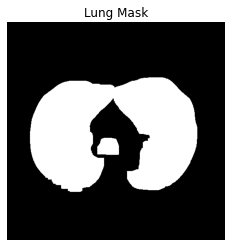

In [21]:
# testing make_lung_mask function
img_lung_mask = make_lung_mask(img_open)

fig, ax = plt.subplots(1, 1, figsize=[4, 4])
ax.imshow(img_lung_mask, cmap='gray')
ax.set_title('Lung Mask')
ax.axis('off')

Then we apply `make_lung_mask` to all images recursively and save lung mask image as numpy array file.

In [22]:
def make_lung_masks(data_path, testing=False):
    if testing:
        working_path = data_path + "test_output/"
    else:
        working_path = data_path + "output/"
    file_list = glob.glob(os.path.expanduser(working_path + 'images*'))
    for file in tqdm(file_list):
        images = np.load(file)
        masks = []
        for img in images:
            img_thred = thresholding(img, classes=2)
            img_open = opening(img_thred, np.ones((4, 4)), np.ones((10, 10)))
            img_lung_mask = make_lung_mask(img_open)
            masks.append(img_lung_mask)
        masks = np.array(masks)
        np.save(file.replace("images", "lung_masks"), masks)

In [472]:
# generate lung masks
make_lung_masks(data_path)

100%|██████████| 1186/1186 [08:15<00:00,  2.39it/s]


To obtain the region of interest, we apply lung masks to the image by simple array multiplication $img = img * mask$. Because mask only has value 0 or 1, after multiplication, the background pixel value will be 0 and the pixel values inside lung region are preserved. Then we rescale pixel values to range [0 - 1] and then resize the image to make the lung object bigger.

After all images are processed, we shuffle the images and take 20% of images to be testing dataset.

In [23]:
def img_process(path, correction=None, testing=False):
    """
    create region of interest from lung mask, resize image and then forming dataset.
    
    correction is to apply gamma or log correction to images if specified
    correction takes in a list with first element to be the name of correction (either 'gamma', or 'log')
    and second element to be the parameter of correction
    for example: correction = ["gamma", 2]
    """
    
    if testing:
        working_path = path + "test_output/"
    else:
        working_path = path + "output/"
        
    file_list=glob.glob(working_path+"lung_masks*.npy")
    
    out_images = []      #final set of images
    out_nodemasks = []   #final set of nodemasks
    
    for fname in tqdm(file_list):

        imgs_to_process = np.load(fname.replace("lung_masks", "images"))
        masks = np.load(fname)
        node_masks = np.load(fname.replace("lung_masks", "node_masks"))
        
        for i in range(len(imgs_to_process)):
            
            ## step 1: create region of interest from lung mask
            mask = masks[i]
            node_mask = node_masks[i]
            img = imgs_to_process[i]
            new_size = [512,512] 
            img = mask*img # apply lung mask
            
            # renormalizing the masked image (in the mask region)

            new_mean = np.mean(img[mask>0])  
            new_std = np.std(img[mask>0])
            #
            #  Pulling the background color up to the lower end
            #  of the pixel range for the lungs
            #
            old_min = np.min(img)       # background color
            img[img==old_min] = new_mean-1.2*new_std   # resetting backgound color
            img = img - new_mean
            img = img / new_std
            
            ## step 2: resize image
            # recursively searching lung bounding box from mask regions
            labels = measure.label(mask)
            regions = measure.regionprops(labels)
            min_row = 512
            max_row = 0
            min_col = 512
            max_col = 0
            for prop in regions:
                boundary = prop.bbox
                if min_row > boundary[0]:
                    min_row = boundary[0]
                if min_col > boundary[1]:
                    min_col = boundary[1]
                if max_row < boundary[2]:
                    max_row = boundary[2]
                if max_col < boundary[3]:
                    max_col = boundary[3]
            width = max_col-min_col
            height = max_row - min_row
            if width > height:
                max_row = min_row + width
            else:
                max_col = min_col + height

            # cropping the image down to the bounding box
            img = img[min_row:max_row,min_col:max_col]
            mask =  mask[min_row:max_row,min_col:max_col]
            if max_row-min_row <5 or max_col-min_col<5:  # skipping all images with no god regions
                pass
            else:
                # moving pixel range to 0 to 1 in order to use skimage.resize function
                img_min = np.min(img)
                img_max = np.max(img)
                img = (img - img_min)/(img_max - img_min)
                resized_img = resize(img, [512,512])
                resized_node_mask = resize(node_mask[min_row:max_row, min_col:max_col],[512, 512])
                # bring mask value back to 0 and 1
                resized_node_mask = np.where(resized_node_mask > 0, 1, 0)
                
                ## step 3: apply correction if needed
                if correction[0] == 'gamma':
                    resized_img = exposure.adjust_gamma(resized_img, correction[1])
                    file_name = "_" + correction[0] + str(correction[1])
                elif correction[0] == 'log':
                    resized_img = exposure.adjust_log(resized_img, correction[1])
                    file_name = "_" + correction[0] + str(correction[1])
                else:
                    file_name = ""
                
                out_images.append(resized_img)
                out_nodemasks.append(resized_node_mask)

    num_images = len(out_images)
    #
    #  Writing out images and masks as 1 channel arrays for input into network
    #
    final_images = np.ndarray([num_images, 1, 512, 512],dtype=np.float32)
    final_masks = np.ndarray([num_images, 1, 512, 512],dtype=np.float32)
    for i in range(num_images):
        final_images[i,0] = out_images[i]
        final_masks[i,0] = out_nodemasks[i]
        
    ## step 4: shuffle and forming training set and testing set.
    rand_i = np.random.choice(range(num_images), size=num_images, replace=False)
    test_i = int(0.2 * num_images)
    np.save(working_path+"trainImages{}.npy".format(file_name), final_images[rand_i[test_i:]])
    np.save(working_path+"trainMasks{}.npy".format(file_name), final_masks[rand_i[test_i:]])
    np.save(working_path+"testImages{}.npy".format(file_name), final_images[rand_i[:test_i]])
    np.save(working_path+"testMasks{}.npy".format(file_name), final_masks[rand_i[:test_i]])

In [536]:
# generate dataset
img_process(data_path)

 10%|█         | 124/1186 [00:07<00:59, 17.88it/s]/Users/jun/.pyenv/versions/ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/jun/.pyenv/versions/ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/jun/.pyenv/versions/ml/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jun/.pyenv/versions/ml/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/Users/jun/.pyenv/versions/ml/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 1186/1186 [01:11<00:00

Now we have our data ready for machine learning.

**Sanity Check of processed images**

In [24]:
def load_data(path, purpose, testing=False):
    if testing:
        working_path = path + "test_output/"
    else:
        working_path = path + "output/"
        
    X = np.load(working_path + purpose + "Images.npy")
    Y = np.load(working_path + purpose + "Masks.npy")
    return X, Y

Text(0.5, 1.0, 'trainY: nodule mask')

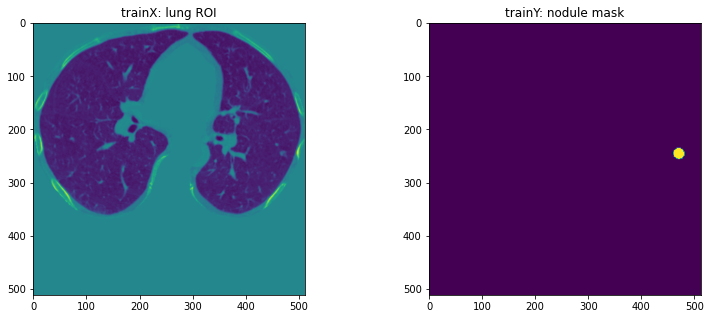

In [26]:
trainX, trainY = load_data(data_path, 'train', testing=False)
testX, testY = load_data(data_path, 'test', testing=False)
mask = trainY[4, 0, :, :]
img = trainX[4, 0, :, :]

figure, axs = plt.subplots(1, 2, figsize=[13, 5])
axs[0].imshow(img)
axs[0].set_title("trainX: lung ROI")
axs[1].imshow(mask)
axs[1].set_title("trainY: nodule mask")

In [27]:
print("training data shape: {} \ntraining lable shape: {} \ntesting data shape: {} \ntesting label shape: {}".format(trainX.shape, trainY.shape, testX.shape, testY.shape))

training data shape: (2843, 1, 512, 512) 
training lable shape: (2843, 1, 512, 512) 
testing data shape: (710, 1, 512, 512) 
testing label shape: (710, 1, 512, 512)


Training set size is 2843 images, testing set size is 710. All images have channel first format. Tensorflow currently doesn't support channel first format on CPU training, therefore we need to move channel to the end by using `ndarray.transpose`.

In [28]:
trainX = trainX.transpose(0, 2, 3, 1)
trainY = trainY.transpose(0, 2, 3, 1)
testX = testX.transpose(0, 2, 3, 1)
testY = testY.transpose(0, 2, 3, 1)

In [29]:
print("Image shape is {} after transpose.".format(trainX.shape[1:]))

Image shape is (512, 512, 1) after transpose.


In [120]:
img = trainX[0, :, :, 0]
value, counts = np.unique(img, return_counts=True)
print("Image pixel value statistic:")
print(pd.Series(img.flatten()).describe())
print("Image pixel values are in range 0 to 1.")

Image pixel value statistic:
count    512.000000
mean       0.288625
std        0.015001
min        0.254250
25%        0.285712
50%        0.285712
75%        0.285712
max        0.383707
dtype: float64
Image pixel values are in range 0 to 1.


In [72]:
mask = trainY[0, :, :, 0]
print("Nodule mask only has value {}.".format(np.unique(mask)))

Nodule mask only has value [0. 1.].


## Model and Training

### Training in the cloud workflow

We use `tensorflow_cloud` api to train the model in Google AI Platform.

There are several advantages of this method:

* distribution strategy is automatic
* cost is low and flexible
* able to run multiple models concurrently
* use `tfc.remote()` api to have two seperate sets of parameters for running locally and running in the cloud

In order to do that, we need to define the model in a python script (`train.py`) and cloud training api call in a seperate python script (`scale.py`). Training data is stored in Google storage bucket, cloud computing will load data from there.

After training is done, training history will be saved as a json file in the bucket as well as trained model in SavedModel format. We then download those files from cloud for analysis and prediction.

### Base Model

Our model is a deep learning convolutional neural network.

**Convolutional Neural Network - CNN**
Unlike neural networks, convolutional neutral networks can take objects with more than on dimension as input and allow for the extraction of features from images.
Furthermore, since images are typically 3D objects (width, height, 3) that have a large number of cells, using fully connected neural networks where each output neuron is connect to all input neurons would be extremely costly.<br>
In CNN each output neuron is connected to a set of input neurons using what is called a kernel or a filter. Filters correspond to the weights in a normal neural network and are learned in the training step.
In this application our images are grayscale, with 512x512 pixels.<br>
In practice, for each different filter a convolution extracts a different feature of the image such as edges, horizontal lines, vertical lines. It can also accentuate granularity, or remove it.

**Architecture**
We use a 'U-Net' architecture which consists of 2 branches, contracting and expanding.

U-Net Architecture
![imgs/u_net.png](imgs/u_net.png)

- Contracting is a sequence of convolutions, ReLu and Maxpooling. Each convolution extracts a number of features,each into a separate channel. ReLu is an activation function that sets pixels that are not of interest to zero. Maxpooling then reduces the size of each image by breaking the image into subsets and only keeping the maximum pixel in that subset. At the bottom of this branch the image is broken down into a large set of features.

Convolution
![Convolution.png](imgs/Convolution.png)

- Expanding is a sequence of upsampling (ConvTranspose, concatenating),convolutions, and ReLu. This stage enables precise localization. This is achieved by first applying a Convolutional transpose which basically consists of doubling the size of image by introducing zero pixels in between existing pixels. Then concatenating the image with its corresponding image from the contraction side, using the convolution operation to add localization information to the existing context. This reduces the number of feature channels and increases the size of the image 

Convolution Transpose
![ConvTranspose.png](imgs/ConvTranspose.png)

- The last layer is a sigmoid or a softmax to classify each pixels of the image. In our case it is a sigmoid since the ouput value is either 1 (nodule) or 0 (not nodule).


#### Parameters

- Filter size: 3x3
- Number of filters: We start with 32 filters and multiply the number of filters by 2 at each layer 
- Pool size: 2x2
- Activation: ReLu
- Padding: "same" pads the image with zeroes so that the output image has the same size as the input
- Strides: (2,2) the number of pixels to move the filter in x,y directions respectively,  after each operation
- Optimizer: We use ADAM which is the current state of the art for gradient descent. It is fast and works with large data
- Loss function: We use the Dice coefficent loss function

#### Training

With this configuration we started with 32 filters, and multiplied the number of filters by 2 at each contraction step, to 512 filters at the bottom of the U-shape. We had a total of 7.85e+6 parameters. We ran 60 epochs. <br>
Running time was 3 minutes per epoch on an NVIDIA Tesla T4

#### Loss function and metric

For the metric function we use the Dice Coefficient which is an F1 score. It is calculated as $\frac {2|𝑋\cap|𝑌|}{|𝑋|\cup|𝑌|}$  or  $\frac {2𝑇𝑃}{2𝑇𝑃+𝐹𝑃+𝐹𝑁}$. <br>
Pixel accuracy is not a good metric for our problem because the area we are interested in is very small compared to the size of the image. So for example a totally blank mask will have an accuracy above 95% because more than 95% of the pixels in the mask are blank. <br>
The loss function is simply -1 * Dice Coefficient, a number between -1 and 0 (in some cases 1-Dice coefficient is used which gives a number between 0 and 1 and is more intuitive)

In [30]:
# metric
def dice_coef(y_true, y_pred):
    """
    use dice coefficient as metric
    """
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# loss function
def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [31]:
def plot_model_dc(model_name):
    """
    plot dice coefficient of training and validation for a given model
    """
    with open(os.path.join('history', '{}.json'.format(model_name))) as f:
        history = json.load(f)
    fig, ax = plt.subplots(figsize=[10, 6])
    ax.plot(range(1, 61), history['dice_coef'], label='training data')
    ax.plot(range(1, 61), history['val_dice_coef'], label='validation data')
    ax.legend()
    ax.set_title('{}'.format(model_name))
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Dice Coefficient')

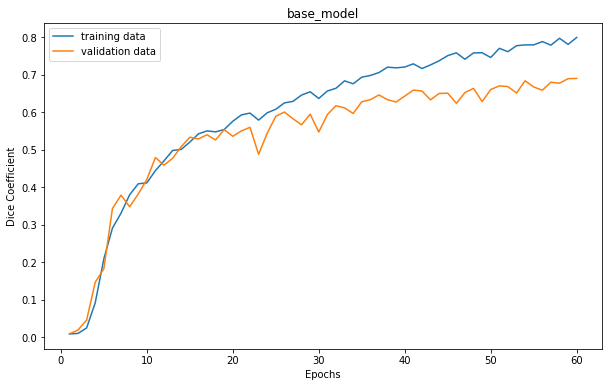

In [32]:
plot_model_dc("base_model")

The code of the base model can be found at models/base_model/train.py <br>
This code was run in Google AI Platform.

The Unet model seems to have been a good choice because the performance of the model is satisfactory. The base model was run for 60 epochs. At the end of training, the training data had a dice coefficent of 0.799 and the validation data had a dice coefficent of 0.690. We hypothesize that one reason the training data set has a higher dice coefficent may have been because of overfitting.

### Variations

To understand how different parameters affect the base model, we varied the parameters to see how they impact the overall performance. In order to isolate the effect of each feature change, we only changed one feature at a time. The variations are described in the table below.

In [5]:
from tabulate import tabulate
model_variations = pd.read_csv('models/descriptions.csv', index_col="model_name")
print(tabulate(model_variations, headers='keys'))

model_name     description
------------  ------------------------------------------------------
base_model    u_net base model
lr001         learning rate 0.001
filters_64    starts with 64 filters on u_net
batch_n       with batch normalization at each step
dropout       adds dropout function between the convolutional layers
binary        a unet using binary_crossentropy as the loss function
add_layers    add 2 more convolutional blocks to u_net
log_2         log contrast adjustment with log=2
gamma_2       gamma contrast adjustment with gamma=2


Below, we explain each variation, present any hypothesis and discuss the impacts of the variation on the model:

* **Learning Rate** used in base model is $10^{-5}$. We also tried learning rate of $10^{-3}$ and $10^{-4}$. From the graph we can tell, $10^{-3}$ and $10^{-4}$ are too big for this problem, which results over shooting and struggle to find minimum.

In [36]:
def plot_dice_coef(model_names):
    """
    plot validation dice coefficient of selected models
    """

    # create dice coefficient array from history json files

    # file names under directory `history`
    history_files = ["history/"+f+".json" for f in model_names]

    history_lst = []

    for file in history_files:
        # load json file into dictionary
        with open(file) as f:
            history = json.load(f)
        # create a list of history dictionaries
        history_lst.append(history)

    dice_arr = np.array([x["val_dice_coef"] for x in history_lst])

    # plot dice coefficient of all models
    num_models, epochs = dice_arr.shape
    model_names = [name.split('.')[0] for name in history_files]

    fig, ax = plt.subplots(figsize=[10, 6])
    for i in range(num_models):
        ax.plot(range(1, epochs+1), dice_arr[i, :], label=model_names[i].replace('history/', ''))
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Dice Coefficient (validation)')
    ax.legend(loc="best")

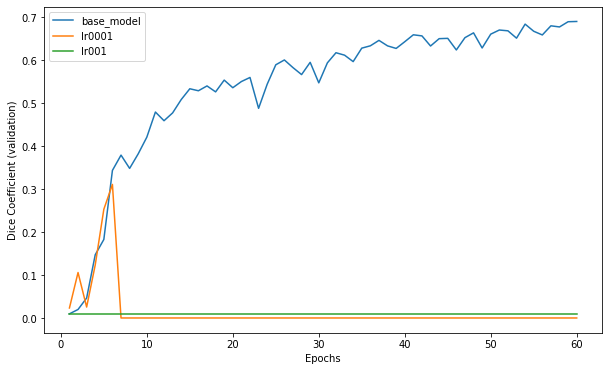

In [37]:
plot_dice_coef(["base_model", "lr0001", "lr001"])

- **Batch Normalization** consists in normalizing each batch at every layer. There is currently no consensus on why it works, but it has been observed that it makes neural networks faster and more stable. That is actually what we observed, with the dice coefficient improving slightly from 0.789 to 0.809 after 60 epoch, but increasing more steadily as the number of epochs increased. The Dice coefficient of the validation data, however, was extremely unstable.  

In [33]:
def plot_train_dice_coef(model_names):
    """
    plot validation dice coefficient of selected models
    """

    # create dice coefficient array from history json files

    # file names under directory `history`
    history_files = ["history/"+f+".json" for f in model_names]

    history_lst = []

    for file in history_files:
        # load json file into dictionary
        with open(file) as f:
            history = json.load(f)
        # create a list of history dictionaries
        history_lst.append(history)

    dice_arr_train = np.array([x["dice_coef"] for x in history_lst])
    dice_arr = np.array([x["val_dice_coef"] for x in history_lst])

    # plot dice coefficient of all models
    num_models, epochs = dice_arr.shape
    model_names = [name.split('.')[0] for name in history_files]

    fig, ax = plt.subplots(2,1,figsize=[10, 10])
    for i in range(num_models):
        ax[1].plot(range(1, epochs+1), dice_arr[i, :], label=model_names[i].replace('history/', ''))
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Dice Coefficient (validation)')
    ax[1].legend(loc="best")
    for i in range(num_models):
        ax[0].plot(range(1, epochs+1), dice_arr_train[i, :], label=model_names[i].replace('history/', ''))
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Dice Coefficient (training)')
    ax[0].legend(loc="best")

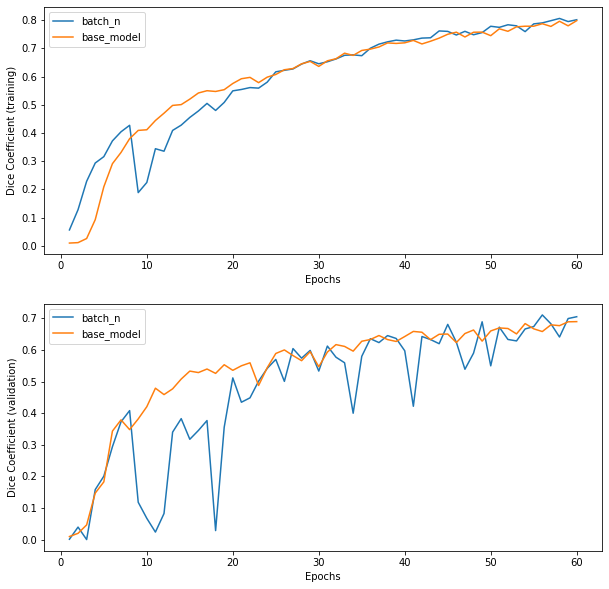

In [34]:
plot_train_dice_coef(['batch_n','base_model'])

- **Dropout** ensures that the data and connections are randomly dropped (see image below). It aims to prevent overfitting of the model. However, in recent years, Dropout has fallen out of favor for BatchNormalization. Both try to prevent overfitting but the Dropout function only works for fully connected layers. Also the BatchNormalization model often performs better than the Dropout function. We expected the Dropout model to perform better than the Base model but not better than the Batch Normalization model. Unfortunately, the dropout model didn't perform better than the base model; it had dice coefficient of 0.582 to 0.690 for the validation data. This may be because the too much data was randomly dropped affecting the performance of the overall model.

![dropout.png](imgs/dropout.png)

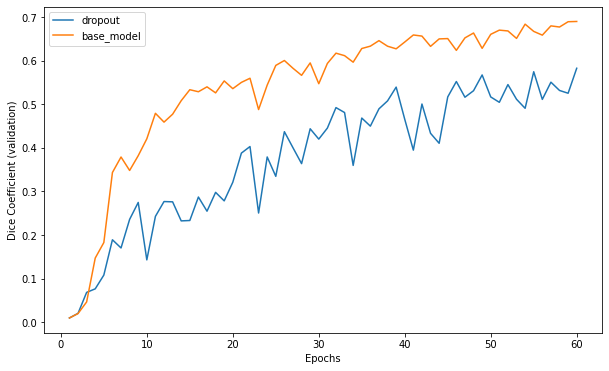

In [38]:
plot_dice_coef(['dropout','base_model'])

- **Addition of layers** results in extracting additional features from the input images before expanding them back to their original size. We added two contraction layers and two corresponding expansion layers so that at the "bottom" stage, we had 2048 feature channels. As expected, adding additional layers improved the Dice coefficient of the model by a small amount, from 0.789 for the base model to 0.824.

* **Increase number of filters** helped the model to extract features from more perspectives. The base model starts with 32 filters and doubled in each convolutional block. In `filters_64` model, number of filters starts with 64 and also doubled in each convolutional block. As illustrated below, with increased number of filters, the dice coefficient is higher than base model, but the difference becomes smaller with more epochs. 

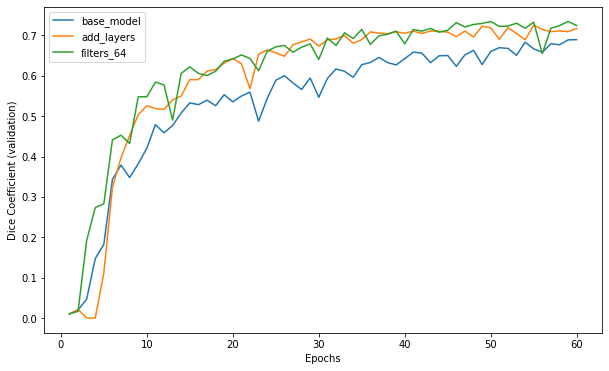

In [39]:
plot_dice_coef(["base_model", "add_layers", "filters_64"])

- **Binary** uses the Binary Crossentropy loss function. The binary crossentropy is primarily used for binary classification. In our case, we are trying to classify each pixel as having no nodule(0) or nodule(1). So, the binary loss function is perfect. However, it is is not a good as the dice coefficient loss function because our training images by default have more no nodules (background) than nodules (foreground), so the binary crossentropy loss function will be biased and unlike the dice coefficient doesn't adjust for this irregularity. Therefore, we expected this model to not perform as well as the base model. As expected the Binary crossentropy loss function model only provided us a dice coefficent of 0.099 to 0.690 for the validation dataset.

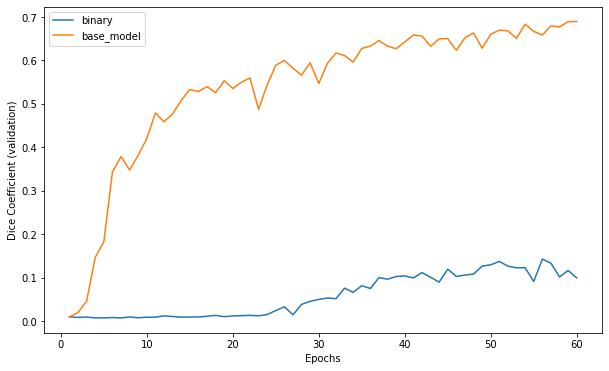

In [40]:
plot_dice_coef(['binary','base_model'])

* **Image Contrast Adjustment** is to use non-linear function to transform pixel values into another dimension. By doing that, we hope to increase the variation of nodule pixel values, so that it might be easier to train the model. We tried 2 types of adjustment, gamma adjustment with gamma equals to 2 and log adjustment with coefficient equals to 2. Both adjustments don't meet our expectation. The log adjustment has 0 dice coefficient. The reason might be the transformation suppressed the nodule information too much, which results the model couldn't tell the difference between nodule and lung. The gamma 2 transformation has dice coefficient less than the base model. The reason might be the nodule pixel values are not in a fixed range. Big nodules and small nodules look very differently. While we increase the variation in one kind of nodule, we might decrease the variation in another kind of nodule at the same time. Therefore the result is not as good as our expectation.

In [22]:
# generate dataset with log adjustment
img_process(data_path, correction=["log", 2])

 11%|█         | 125/1186 [00:09<01:16, 13.84it/s]/Users/jun/.pyenv/versions/ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/jun/.pyenv/versions/ml/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/jun/.pyenv/versions/ml/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jun/.pyenv/versions/ml/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/Users/jun/.pyenv/versions/ml/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 1186/1186 [01:32<00:00

In [23]:
# generate dataset with gamma adjustment
img_process(data_path, correction=["gamma", 2])

100%|██████████| 1186/1186 [01:09<00:00, 17.08it/s]


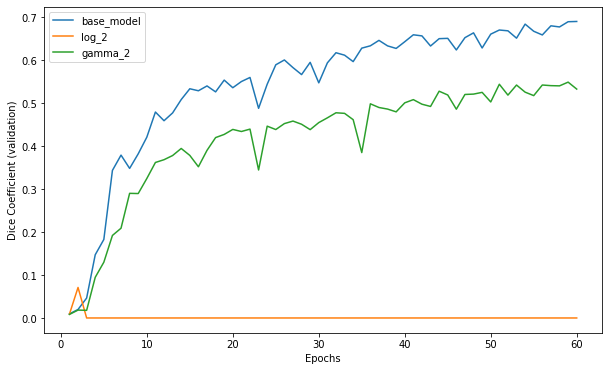

In [41]:
plot_dice_coef(['base_model', 'log_2', 'gamma_2'])

#### Summary of Dice Coefficients

In [48]:
from tabulate import tabulate

models = ['base_model','add_layers','batch_n','binary','dropout','filters_64','lr001','lr0001','gamma_2','log_2']
column=['dice_coeff','val_dice_coeff']

data = []
df = []

for i in range(len(models)):
    with open('history/'+models[i]+'.json','r') as f:
        history = json.load(f)
    data.append([history['dice_coef'][59], history['val_dice_coef'][59]])
df = pd.DataFrame(data, index = models, columns = column)
df.sort_values('val_dice_coeff', ascending=False, inplace=True)
print(tabulate(df, headers='keys', tablefmt='psql'))

+------------+--------------+------------------+
|            |   dice_coeff |   val_dice_coeff |
|------------+--------------+------------------|
| filters_64 |  0.855965    |      0.724526    |
| add_layers |  0.82472     |      0.717263    |
| batch_n    |  0.801918    |      0.705169    |
| base_model |  0.798679    |      0.689649    |
| dropout    |  0.643763    |      0.582342    |
| gamma_2    |  0.682531    |      0.532412    |
| binary     |  0.130862    |      0.0995956   |
| lr001      |  0.0093891   |      0.00967359  |
| log_2      |  0.000147102 |      0.000162186 |
| lr0001     |  0.00013037  |      0.000142557 |
+------------+--------------+------------------+


Of all variations, the filters_64 and add_layers improved the validation set's Dice coefficient. Some variations,such as lr001 and lr0001 illustrate the importance of setting the parameters (learning rate in this case) to the right value.

### Prediction

Use `keras.models.load_model` api to load trained base model.

In [6]:
# load model

# define custom_bojects for loading model
custom_objects = {"dice_coef_loss": dice_coef_loss, "dice_coef": dice_coef}
base_model = tf.keras.models.load_model('saved_models/base_model', custom_objects=custom_objects)

In [8]:
base_model.summary()

Model: "base_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 256, 256, 32) 0           conv2d_1[0][0]                   
_________________________________________________________________________________________

In [16]:
test_pred = base_model.predict(testX)

Finally, we used out test data set to predict the nodules. Below, you can see the left to right the lung CT scan, the annotated nodule, and the predicted nodule.

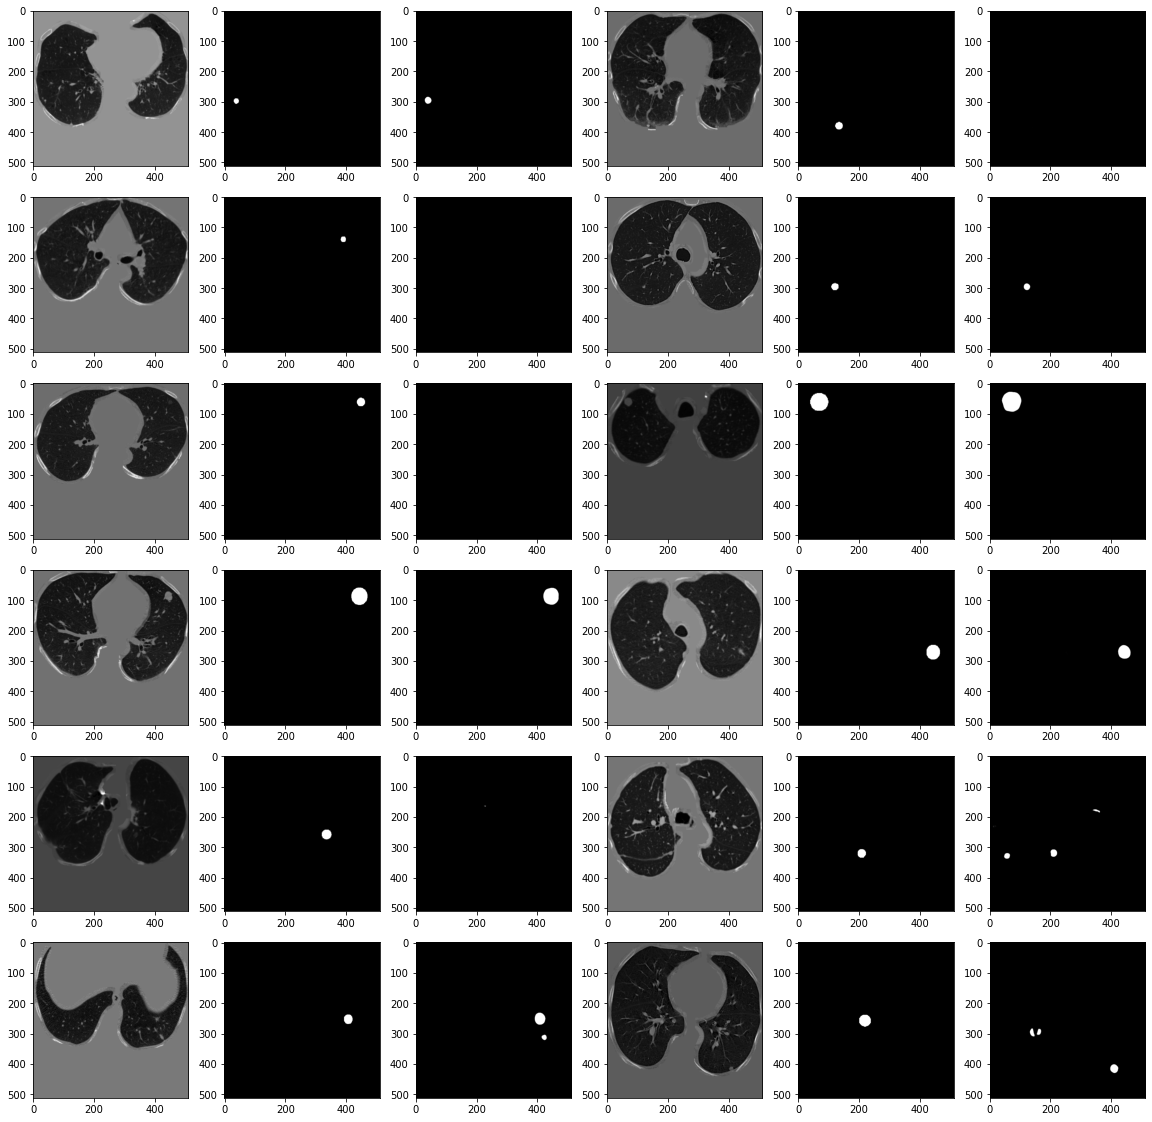

In [18]:
# print
fig, axs = plt.subplots(6, 6, figsize=[20, 20])
k = 0
for i in range(6):
    for j in [0, 3]:
        axs[i, j].imshow(testX[k, :, :, :], cmap='gray')
        axs[i, j+1].imshow(testY[k, :, :, :], cmap='gray')
        axs[i, j+2].imshow(test_pred[k, :, :, :], cmap='gray')
        k += 1

### Conclusion

In this project we put together a semantic segmentation model to detect nodules in lung CT scans. Our data and base model were obtained from Kaggle's 2017 Data Science bowl. We used a convolutional neural network in a U-Net architecture. We then changed one feature of the algorithm at a time in order to improve the model's performance. Most improvements were marginal. 
In this project data preparation turned out to be the most important step of the project.

### Future Explorations

Up to now we only varied some features of the algorithm, and one at a time. It would be interesting to explore what features make a real difference in the model's performance and also what combinations of feature changes would do a better job with the model.

If we had more time, there are a few other models we would have liked to explore such as UNet++ and ResNet. In fact, we partially implemented the ResNet model but didn't have time to adapt it for image segmentation. In the ResNet model, we built a ResNet image classification model instead of a unet model using a Binary Crossentropy loss function. Unets with many layers this can impact the performance of the model. So the ResNet model basically allows for a skipping layers when it matches the equation f(x) = x (see image below). For UNets with deep layers, the ResNet might provide performance as an overall model. However, we didn't have time to adapt the ResNet model for image segmentation.

![resnet.png](imgs/resnet.png)

### References

Data Science Bowl 2017
https://www.kaggle.com/c/data-science-bowl-2017/overview/tutorial

U-Net: Convolutional Networks for Biomedical Image Segmentation, Olaf Ronneberger, Philipp Fischer, and Thomas Brox.
https://arxiv.org/pdf/1505.04597.pdf

Metrics to Evaluate Your Semantic Segmentation Model
https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2

Dropout 
https://www.kdnuggets.com/2018/09/dropout-convolutional-networks.html https://d2l.ai/chapter_convolutional-modern/resnet.html

Residual Networks
https://d2l.ai/chapter_convolutional-modern/resnet.html

Understanding Binary CrossEntropy
https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a

Build a custom ResNet
https://towardsdatascience.com/build-a-custom-resnetv2-with-the-desired-depth-92892ec79d4b

Implementing a ResNet in Keras
https://www.youtube.com/watch?v=qMFKsMeE6fM

Image Segmentation using UNet
https://www.youtube.com/watch?v=68HR_eyzk00&list=RDCMUC34rW-HtPJulxr5wp2Xa04w&index=6

How to Train UNet on your Dataset
https://medium.com/coinmonks/learn-how-to-train-u-net-on-your-dataset-8e3f89fbd623

Understanding Semantic Segmentation
https://towardsdatascience.com/understanding-semantic-segmentation-with-unet-6be4f42d4b47